In [1]:
import json
import requests
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

In [2]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

In [3]:
hist.head(5)

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2020-07-11,9302.22,9188.13,9288.57,11785.42,1.088998e+08,9237.13,direct,
2020-07-12,9339.99,9169.13,9237.13,16385.50,1.516494e+08,9300.95,direct,
2020-07-13,9336.42,9201.18,9300.95,25872.33,2.400818e+08,9237.89,direct,
2020-07-14,9279.57,9109.70,9237.89,25865.27,2.383085e+08,9256.07,direct,
2020-07-15,9272.57,9160.89,9256.07,23480.12,2.163869e+08,9193.22,direct,


In [4]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data
train, test = train_test_split(hist, test_size=0.2)

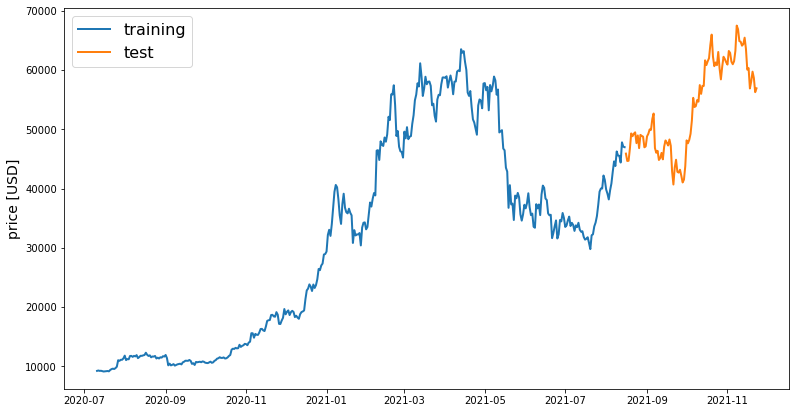

In [27]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [6]:
def normalise_zero_base(df):
    #print(df.iloc[0])
    return df 

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [7]:
def extract_window_data(df, window_len=5, zero_base=False):
    window_data = []
    
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    # print(train_data.shape)
    X_train = extract_window_data(train_data, window_len, zero_base)
    # print(X_train.shape)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values

    print(len(train_data[target_col][:-window_len].values-1))
    print(len(y_train))
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1
    print(X_train, y_train)

    return train_data, test_data, X_train, X_test, y_train, y_test

In [8]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [9]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [10]:
train, test, X_train, X_test, y_train, y_test = prepare_data(hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

X_train = X_train[:,:,:-3]


print(X_train.shape)


model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,optimizer=optimizer)

X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)


history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

(401, 8)
(396, 5, 8)
396
396
[[[9302.22 9188.13 9288.57 ... 9237.13 'direct' '']
  [9339.99 9169.13 9237.13 ... 9300.95 'direct' '']
  [9336.42 9201.18 9300.95 ... 9237.89 'direct' '']
  [9279.57 9109.7 9237.89 ... 9256.07 'direct' '']
  [9272.57 9160.89 9256.07 ... 9193.22 'direct' '']]

 [[9339.99 9169.13 9237.13 ... 9300.95 'direct' '']
  [9336.42 9201.18 9300.95 ... 9237.89 'direct' '']
  [9279.57 9109.7 9237.89 ... 9256.07 'direct' '']
  [9272.57 9160.89 9256.07 ... 9193.22 'direct' '']
  [9216.53 9029.17 9193.22 ... 9133.23 'direct' '']]

 [[9336.42 9201.18 9300.95 ... 9237.89 'direct' '']
  [9279.57 9109.7 9237.89 ... 9256.07 'direct' '']
  [9272.57 9160.89 9256.07 ... 9193.22 'direct' '']
  [9216.53 9029.17 9193.22 ... 9133.23 'direct' '']
  [9183.08 9080.61 9133.23 ... 9156.79 'direct' '']]

 ...

 [[45310.33 43300.59 44617.96 ... 43827.75 'direct' '']
  [46476.01 42818.07 43827.75 ... 46292.61 'direct' '']
  [46707.56 44663.2 46292.61 ... 45601.03 'direct' '']
  [46763.89 453

13/13 [==============================] - 0s 3ms/step - loss: 0.0862
Epoch 3/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0842
Epoch 4/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0817
Epoch 5/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0700
Epoch 6/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0675
Epoch 7/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0569
Epoch 8/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0583
Epoch 9/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0503
Epoch 10/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0446
Epoch 11/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0403
Epoch 12/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0471
Epoch 13/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0407
Epoch 14/20
13/13 [==============================] - 0s 3ms

In [11]:
targets = test[target_col][window_len:]
X_test = X_test[:,:,:-3]
X_test = np.asarray(X_test).astype(np.float32)

preds = model.predict(X_test).squeeze()

print(preds[0:10])
print(y_test[:10])

print(y_test.mean(), preds.mean(), (y_test - preds).mean())
print()
mean_absolute_error(preds, y_test)


[0.01753585 0.01753585 0.01753585 0.01753585 0.01753585 0.01753585
 0.01753585 0.01753585 0.01753585 0.01753585]
[ 0.06402431  0.1030623   0.10749345  0.01986784 -0.00689166 -0.04124694
 -0.00409031 -0.01215968  0.02314337 -0.04088317]
0.014582008101744386 0.017535847 -0.0029538404413035194



0.05895455223903767

In [26]:
for i in range(1, 21):
    # print(len(y_train[len(y_train)-i:]), len(y_test[:-i]))
    bl_pred = np.concatenate((y_train[len(y_train)-i:], y_test[:-i]))
    print(mean_absolute_error(bl_pred, y_test))

0.03654268135827683
0.05137056893928061
0.06443112952745306
0.07226216919538161
0.07893354644828471
0.0815275037901303
0.08400138474921982
0.08245224754281436
0.08457111548140929
0.0810573807687693
0.08175763066093936
0.0830560519922591
0.08227497724537071
0.08333447482442309
0.08912657852713111
0.0895378659177756
0.09114557689318034
0.09206364176861122
0.09506147466916284
0.09575777237530014


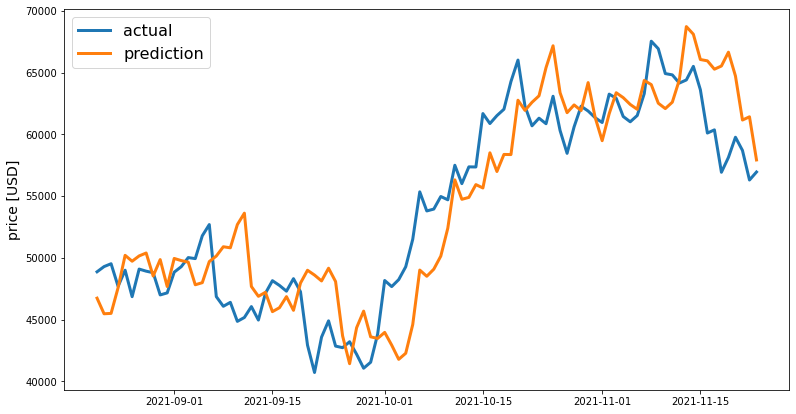

In [13]:
preds = test[target_col].values[:-window_len] * (preds+1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)
